In [186]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
# HPI / RPI exploration

In [2]:
hpi_base = open("hpi_base.pkl","rb")
hpi = pd.read_pickle(hpi_base)
hpi = pd.DataFrame(hpi)
hpi.head(20)

,period_start,period_end,trans_period,coef,price_index,census_zcta5_geoid,census_cbsa_geoid
0,2007-01-01,2007-01-31,1.0,0.000000,100.000000,00000,11460
1,2007-02-01,2007-02-28,2.0,-0.018513,98.165768,00000,11460
2,2007-03-01,2007-03-31,3.0,-0.016101,98.402746,00000,11460
3,2007-04-01,2007-04-30,4.0,-0.014683,98.542442,00000,11460
4,2007-05-01,2007-05-31,5.0,-0.049284,95.191042,00000,11460
5,2007-06-01,2007-06-30,6.0,-0.056957,97.460913,00000,11460
6,2007-07-01,2007-07-31,7.0,-0.080070,96.178445,00000,11460
7,2007-08-01,2007-08-31,8.0,-0.090466,95.042580,00000,11460
8,2007-09-01,2007-09-30,9.0,-0.092902,93.830170,00000,11460
9,2007-10-01,2007-10-31,10.0,-0.076260,92.849345,00000,11460


In [13]:
hpi.shape
# 2 million observations

(2289507, 7)

In [3]:
len(hpi['census_cbsa_geoid'].unique()) # 91 markets
len(hpi['census_zcta5_geoid'].unique()) # 11189 zip codes
len(hpi['trans_period'].unique()) # 200 periods, monthly from 2007 to present

200

In [3]:
rpi_index = open("rpi_index.pkl","rb")
rpi = pd.read_pickle(rpi_index)
rpi = pd.DataFrame(rpi)
rpi = rpi.rename({"date": "period_start"}, axis = 1)
rpi.head(20)

,period_start,rental_index,census_cbsa_geoid,census_zcta5_geoid
0,2010-02-01,100.000000,17140,00000
1,2010-03-01,74.931176,17140,00000
2,2010-04-01,79.105472,17140,00000
3,2010-05-01,70.164398,17140,00000
4,2010-06-01,54.594201,17140,00000
5,2010-07-01,80.757459,17140,00000
6,2010-08-01,78.479249,17140,00000
7,2010-09-01,79.804032,17140,00000
8,2010-10-01,78.491062,17140,00000
9,2010-11-01,76.840681,17140,00000


In [91]:
rpi.shape
# 1.6 million observations

(1684308, 4)

In [93]:
len(rpi['census_cbsa_geoid'].unique()) # 87 markets
len(rpi['census_zcta5_geoid'].unique()) # 11241 zip codes
len(rpi['period_start'].unique()) # 164 dates, monthly from 2010 to present

164

In [97]:
rpi['census_zcta5_geoid'].value_counts()

00000    11897
32162      346
21787      328
23117      328
22546      328
         ...  
34785       18
33521       18
33538       18
33513       18
33585       18
Name: census_zcta5_geoid, Length: 11241, dtype: int64

In [99]:
rpi[rpi['census_zcta5_geoid'] == '00000']

,period_start,rental_index,census_cbsa_geoid,census_zcta5_geoid
0,2010-02-01,100.000000,17140,00000
1,2010-03-01,74.931176,17140,00000
2,2010-04-01,79.105472,17140,00000
3,2010-05-01,70.164398,17140,00000
4,2010-06-01,54.594201,17140,00000
...,...,...,...,...
1675775,2023-04-01,173.400618,49180,00000
1675776,2023-05-01,174.693641,49180,00000
1675777,2023-06-01,175.552431,49180,00000
1675778,2023-07-01,175.585619,49180,00000


In [4]:
# remove market aggregate rows
rpi_clean = rpi[rpi['census_zcta5_geoid'] != '00000']
hpi_clean = hpi[hpi['census_zcta5_geoid'] != '00000']

In [13]:
sfr = pd.merge(rpi_clean, hpi_clean, how = 'left', on = ['period_start', 'census_zcta5_geoid'])
sfr = sfr.drop(['census_cbsa_geoid_x', 'period_end', 'census_cbsa_geoid_y'], axis=1)
sfr = sfr.rename({'rental_index': 'sf_rental_index', 'price_index': 'sf_price_index'}, axis=1)
sfr.head(20)

,period_start,sf_rental_index,census_zcta5_geoid,trans_period,coef,sf_price_index
0,2010-02-01,100.000000,47038,38.0,-0.228594,82.953446
1,2010-03-01,67.975154,47038,39.0,-0.195522,82.872184
2,2010-04-01,78.247524,47038,40.0,-0.185380,82.536945
3,2010-05-01,62.539852,47038,41.0,-0.177184,82.263764
4,2010-06-01,50.101684,47038,42.0,-0.182479,81.827389
5,2010-07-01,78.789211,47038,43.0,-0.204863,82.240525
6,2010-08-01,75.250656,47038,44.0,-0.232298,82.191501
7,2010-09-01,76.243668,47038,45.0,-0.237700,81.625401
8,2010-10-01,73.152480,47038,46.0,-0.252781,80.722894
9,2010-11-01,71.777853,47038,47.0,-0.193331,80.499291


In [14]:
sfr['period_start'] = pd.to_datetime(sfr['period_start'],format = '%Y-%m-%d')

In [53]:
sfr = sfr.rename({'census_zcta5_geoid': 'zipcode'}, axis=1)

In [175]:
sfr['period_start']

0         2010-02-01
1         2010-03-01
2         2010-04-01
3         2010-05-01
4         2010-06-01
             ...    
1719395   2023-04-01
1719396   2023-05-01
1719397   2023-06-01
1719398   2023-07-01
1719399   2023-08-01
Name: period_start, Length: 1719400, dtype: datetime64[ns]

<Axes: xlabel='period_start', ylabel='sf_rental_index'>

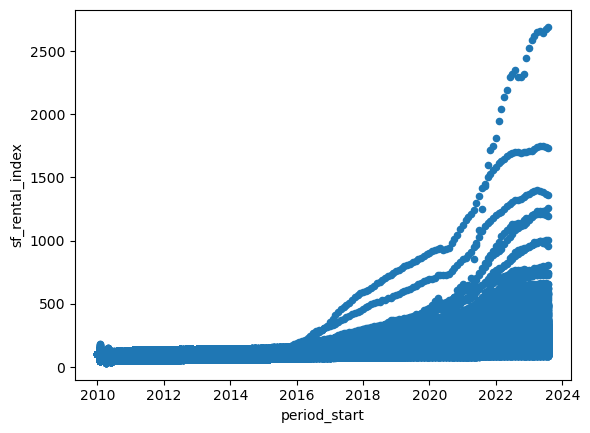

In [16]:
sfr.plot.scatter('period_start','sf_rental_index')

In [ ]:
# Read in migration data

In [22]:
migration_atl = pd.read_csv('area_migration_atlanta_tract.csv', index_col = 0)
migration_atl.head()

,area,us_state_id,us_state,us_cbsa_id,us_cbsa,us_county_id,us_county,us_tract_id,us_tract,observation_start_date,observation_end_date,student_population_fraction,population,netflow_estimated,inflow_estimated,outflow_estimated,netflow_estimated_normalized,inflow_estimated_normalized,outflow_estimated_normalized,cumulative_netflow_estimated,median_income_inflow,median_income,median_income_difference,median_age_inflow,median_age,median_age_difference,confidence_score
location_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
13121005501,1192738,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13121,"Fulton County, GA",13121005501,13121005501,2023-06-01,2023-06-30,0.0877,3045,0,13,13,0,12,12,-73,46088.5742,37342,8746.5732,23.3552,30.6,-7.2448,1
13117130413,5159717,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13117,"Forsyth County, GA",13117130413,13117130413,2023-06-01,2023-06-30,0.0217,2725,5,25,20,5,23,19,315,87631.4922,47383,40248.4922,28.1005,44.9,-16.7995,1
13063040523,2666441,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13063,"Clayton County, GA",13063040523,13063040523,2023-06-01,2023-06-30,0.1003,2821,-1,15,16,-1,14,15,-121,31598.7207,43214,-11615.2783,21.2600,33.3,-12.0400,1
13089022900,3903186,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13089,"DeKalb County, GA",13089022900,13089022900,2023-06-01,2023-06-30,0.0225,4044,1,43,42,1,40,39,133,57696.6094,89792,-32095.3887,29.8097,44.4,-14.5903,1
13121007709,3497343,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13121,"Fulton County, GA",13121007709,13121007709,2023-06-01,2023-06-30,0.1179,4921,-2,21,23,-2,20,21,-8,26437.3164,86637,-60199.6836,20.9190,34.6,-13.6810,1


In [6]:
migration_atl['observation_start_date'].unique() # from Dec 2018 to Jun 2023

array(['2023-06-01', '2023-05-01', '2023-04-01', '2023-03-01',
       '2023-02-01', '2023-01-01', '2022-12-01', '2022-11-01',
       '2022-10-01', '2022-09-01', '2022-08-01', '2022-07-01',
       '2022-06-01', '2022-05-01', '2022-04-01', '2022-03-01',
       '2022-02-01', '2022-01-01', '2021-12-01', '2021-11-01',
       '2021-10-01', '2021-09-01', '2021-08-01', '2021-07-01',
       '2021-06-01', '2021-05-01', '2021-04-01', '2021-03-01',
       '2021-02-01', '2021-01-01', '2020-12-01', '2020-11-01',
       '2020-10-01', '2020-09-01', '2020-08-01', '2020-07-01',
       '2020-06-01', '2020-05-01', '2020-04-01', '2020-03-01',
       '2020-02-01', '2020-01-01', '2019-12-01', '2019-11-01',
       '2019-10-01', '2019-09-01', '2019-08-01', '2019-07-01',
       '2019-06-01', '2019-05-01', '2019-04-01', '2019-03-01',
       '2019-02-01', '2019-01-01', '2018-12-01'], dtype=object)

In [23]:
migration_atl['observation_start_date'] = pd.to_datetime(migration_atl['observation_start_date'],
                                                         format = '%Y-%m-%d')

In [20]:
migration_clev = pd.read_csv('haystacks_cleveland_market_tract_migration.csv', index_col = 0)
migration_clev.head()

,area,us_state_id,us_state,us_cbsa_id,us_cbsa,us_county_id,us_county,us_tract_id,us_tract,observation_start_date,observation_end_date,student_population_fraction,population,netflow_estimated,inflow_estimated,outflow_estimated,netflow_estimated_normalized,inflow_estimated_normalized,outflow_estimated_normalized,cumulative_netflow_estimated,median_income_inflow,median_income,median_income_difference,median_age_inflow,median_age,median_age_difference,confidence_score
location_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
39093097500,6683941,39,Ohio,17460,"Cleveland-Elyria, OH Metro Area",39093,"Lorain County, OH",39093097500,39093097500,2023-06-01,2023-06-30,0.0259,6400,-10,21,31,-9,20,29,-942,28943.1602,34511,-5567.8398,23.5333,45.5,-21.9667,1
39035115900,1282306,39,Ohio,17460,"Cleveland-Elyria, OH Metro Area",39035,"Cuyahoga County, OH",39035115900,39035115900,2023-06-01,2023-06-30,0.0407,2798,-1,7,8,-1,7,7,-212,24193.9863,41414,-17220.0137,26.4410,48.0,-21.5590,1
39093070200,8042626,39,Ohio,17460,"Cleveland-Elyria, OH Metro Area",39093,"Lorain County, OH",39093070200,39093070200,2023-06-01,2023-06-30,0.0247,1900,0,9,9,0,8,8,-47,32141.5000,51141,-18999.5000,26.7538,42.6,-15.8462,1
39093013101,16799130,39,Ohio,17460,"Cleveland-Elyria, OH Metro Area",39093,"Lorain County, OH",39093013101,39093013101,2023-06-01,2023-06-30,0.0279,4811,2,21,19,2,20,18,252,49936.2930,103929,-53992.7070,28.7687,44.5,-15.7312,1
39035119900,571774,39,Ohio,17460,"Cleveland-Elyria, OH Metro Area",39035,"Cuyahoga County, OH",39035119900,39035119900,2023-06-01,2023-06-30,0.0326,1440,1,10,9,1,9,8,-83,45377.1016,19351,26026.0996,27.7050,52.0,-24.2950,1


In [24]:
migration_clev['observation_start_date'] = pd.to_datetime(migration_clev['observation_start_date'],
                                                         format = '%Y-%m-%d')

In [83]:
cbsa = pd.read_csv('census_cbsa_zip_tract.csv', index_col = 0)
cbsa.head(20)
# lat and lon for cbsa, zcta, tracts

,census_cbsa_geoid,census_cbsa_name,census_cbsa_lsad,census_cbsa_lat,census_cbsa_lon,census_zcta5_geoid,census_zcta5_lat,census_zcta5_lon,census_tract_geoid,census_tract_lat,census_tract_lon
0,NaN,NaN,NaN,NaN,NaN,46534,41.285345,-86.617818,18149953800,41.245562,-86.539415
1,NaN,NaN,NaN,NaN,NaN,46534,41.285345,-86.617818,18149953900,41.223357,-86.626671
2,NaN,NaN,NaN,NaN,NaN,46534,41.285345,-86.617818,18149954000,41.288932,-86.621202
3,NaN,NaN,NaN,NaN,NaN,46534,41.285345,-86.617818,18149953700,41.349693,-86.591977
4,21780.0,"Evansville, IN-KY",M1,38.020070,-87.586166,47660,38.296067,-87.328127,18051050300,38.280515,-87.379887
5,27540.0,"Jasper, IN",M2,38.384156,-87.035954,47660,38.296067,-87.328127,18051050300,38.280515,-87.379887
6,14020.0,"Bloomington, IN",M1,39.241736,-86.671754,47424,39.020048,-86.882428,18055955400,39.031930,-86.932400
7,14020.0,"Bloomington, IN",M1,39.241736,-86.671754,47424,39.020048,-86.882428,18055954800,39.110252,-86.922536
8,14020.0,"Bloomington, IN",M1,39.241736,-86.671754,47424,39.020048,-86.882428,18055954701,38.973253,-86.763794
9,47780.0,"Washington, IN",M2,38.696090,-87.076943,47519,38.590053,-86.983857,18027954502,38.602712,-86.992695


In [ ]:
# Multifamily data

In [135]:
mf_occ = pd.read_csv('haystacks_occfile_7-26-2023.csv', index_col = None)
mf_occ.head()

,PID,Period,Occupancy
0,96_872,01/01/2015,97.9
1,96_872,02/01/2015,97.9
2,96_872,03/01/2015,97.7
3,96_872,04/01/2015,97.7
4,96_872,05/01/2015,97.7


In [34]:
len(mf_occ['PID'].unique()) # 62950 PID

62950

In [136]:
mf_occ['Period'] = pd.to_datetime(mf_occ['Period'], format='%m/%d/%Y')
mf_occ['Period'].unique() # 2015 to 2023

array(['2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
       '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
       '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2017-02-01T00:00:00.000000000',
       '2017-03-01T00:00:00.000000000', '2017-04-01

In [137]:
mf_rent = pd.read_csv('haystacks_rent_7-17-2023.csv', index_col = None)
mf_rent.head()

,PID,UnitType,Period,Rent
0,1_1004,1BR,2015-01-01,473.0
1,1_1004,1BR,2015-02-01,475.0
2,1_1004,1BR,2015-03-01,474.0
3,1_1004,1BR,2015-04-01,473.0
4,1_1004,1BR,2015-05-01,472.0


In [37]:
len(mf_rent['PID'].unique()) #64739

64739

In [138]:
mf_rent['Period'] = pd.to_datetime(mf_rent['Period'], format='%Y-%m-%d')
mf_rent['Period'].unique() # 2015 to 2023

array(['2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
       '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
       '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2017-02-01T00:00:00.000000000',
       '2017-03-01T00:00:00.000000000', '2017-04-01

In [139]:
mfr = pd.merge(mf_occ, mf_rent, on = ['PID', 'Period'])
mfr.head(20)
# each PID listed with multiple unit types 
# different rent collected for different units
# occupancy rate is for the whole property

,PID,Period,Occupancy,UnitType,Rent
0,96_872,2015-01-01,97.9,1BR,741.727941
1,96_872,2015-01-01,97.9,2BR/1Bath,861.650000
2,96_872,2015-01-01,97.9,2BR/2Bath,942.677419
3,96_872,2015-02-01,97.9,1BR,752.205882
4,96_872,2015-02-01,97.9,2BR/1Bath,873.250000
5,96_872,2015-02-01,97.9,2BR/2Bath,966.451613
6,96_872,2015-03-01,97.7,1BR,754.970588
7,96_872,2015-03-01,97.7,2BR/1Bath,877.100000
8,96_872,2015-03-01,97.7,2BR/2Bath,957.774194
9,96_872,2015-04-01,97.7,1BR,757.735294


In [17]:
mfr['UnitType'].unique()

array(['1BR', '2BR/1Bath', '2BR/2Bath', '3BR+', 'Studio'], dtype=object)

In [31]:
prop = pd.read_csv('PropertyFileAugust2023.csv', index_col = None)
prop.head()

,Market,Submarket,PID,propertyname,addressall,city,state,zipcode,Longitude,Latitude,nounits,completedyear,propertyquality,locationquality,website,ControlledAccess,FitnessCenter,businesscenter,clubhouse,coveredparking,TotalParkingSpaces,parkingtype,RentOffice,mediaroom,minstories,maxstories,ElevatorServed,wdhookup,wdinunit,SiteSizeAcres,NumberBuildings,county,ParcelComplete,mixeduse,OccupancyDate,Occupancy
0,Albany,1 - Central Albany,151_1100730,Abraxas at 90 State,90 State Street,Albany,NY,12207,-73.753301,42.649623,162,2024.0,NaN,B-,https://www.abraxasat90state.com,Yes,Yes,Yes,Yes,NaN,0.0,None,StandAlone,Y,15.0,15.0,Yes,None,All,0.38,1.0,Albany,010100-076-042-0001-005-000-0000,NaN,NaN,NaN
1,Albany,1 - Central Albany,151_1154,20 Park Residences,20 Park Street,Albany,NY,12207,-73.756933,42.650379,73,2016.0,B+,B-,NaN,Yes,Yes,No,Yes,NaN,28.0,Grade Level,StandAlone,N,5.0,5.0,Yes,None,All,0.44,1.0,Albany,76.33-1-12,No,2023-07-01,0.958904
2,Albany,1 - Central Albany,151_1171488,3rd Avenue & Elizabeth Street,3rd Avenue & Elizabeth Street,Albany,NY,12202,-73.761864,42.639730,100,NaN,NaN,C-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Albany,NaN,NaN,NaN,NaN
3,Albany,1 - Central Albany,151_1179,"Gallery on Holland, The",25 Holland Avenue,Albany,NY,12209,-73.771652,42.646851,60,NaN,NaN,B-,NaN,NaN,Yes,NaN,Yes,NaN,59.0,Multi-Level Structure,NaN,NaN,4.0,4.0,Yes,NaN,NaN,1.10,1.0,Albany,010100-076-047-0001-025-000-0000,NaN,NaN,NaN
4,Albany,1 - Central Albany,151_131,State Street Tower,397 State Street,Albany,NY,12210,-73.765924,42.657046,60,1925.0,C,C+,http://www.statestreettower.com/index.html,Yes,Yes,No,No,NaN,0.0,None,StandAlone,N,3.0,13.0,Yes,None,None,0.18,2.0,Albany,"65.80-3-49.1, 65.80-3-49.2",No,2023-07-01,0.933333


In [228]:
prop['Market'].unique()

array(['Albany', 'Albuquerque', 'Allentown-Bethlehem', 'Amarillo',
       'Anchorage', 'Asheville', 'Athens', 'Atlanta - Suburban',
       'Atlanta - Urban', 'Augusta', 'Austin', 'Baltimore', 'Baton Rouge',
       'Bay Area - East Bay', 'Bay Area - South Bay',
       'Binghamton University', 'Birmingham', 'Boise', 'Boston',
       'Bridgeport - New Haven', 'Brooklyn', 'Buffalo', 'Central Coast',
       'Central East Texas', 'Central Michigan University',
       'Central Valley', 'Charleston', 'Charlotte', 'Chattanooga',
       'Chicago - Suburban', 'Chicago - Urban', 'Cincinnati',
       'Clarksville', 'Cleveland - Akron', 'Colorado Springs', 'Columbia',
       'Columbus', 'Columbus GA', 'Cornell University', 'Corpus Christi',
       'Dallas - North', 'Dallas - Suburban', 'Dayton', 'Denver',
       'Des Moines', 'Detroit', 'East Tennessee State University',
       'El Paso', 'Eugene', 'Fayetteville NC', 'Fort Lauderdale',
       'Fort Wayne', 'Fort Worth', 'Grand Rapids', 'Greenville',

In [32]:
atl_urb_prop = prop[prop['Market'] == 'Atlanta - Urban']
len(atl_urb_prop['PID'].unique()) # 1262 properties

1262

In [45]:
atl_sub_prop = prop[prop['Market'] == 'Atlanta - Suburban']
len(atl_sub_prop['PID'].unique()) # 1356 properties

1356

In [141]:
atl_urb_mfr = pd.merge(mfr, atl_urb_prop, on = 'PID')
atl_urb_mfr = atl_urb_mfr[['PID', 'Period', 'Occupancy_x', 'UnitType', 'Rent', 'nounits', 'zipcode']]
atl_urb_mfr.head(20)

,PID,Period,Occupancy_x,UnitType,Rent,nounits,zipcode
0,22_53,2015-01-01,95.3,1BR,514.0,148,30274
1,22_53,2015-01-01,95.3,2BR/1Bath,535.0,148,30274
2,22_53,2015-02-01,95.3,1BR,519.0,148,30274
3,22_53,2015-02-01,95.3,2BR/1Bath,539.0,148,30274
4,22_53,2015-03-01,95.3,1BR,524.0,148,30274
5,22_53,2015-03-01,95.3,2BR/1Bath,551.0,148,30274
6,22_53,2015-04-01,94.6,1BR,529.0,148,30274
7,22_53,2015-04-01,94.6,2BR/1Bath,563.0,148,30274
8,22_53,2015-05-01,95.3,1BR,534.0,148,30274
9,22_53,2015-05-01,95.3,2BR/1Bath,575.0,148,30274


In [36]:
atl_urb_mfr.isna().sum()

PID               0
Period            0
Occupancy_x       0
UnitType          0
Rent           5574
zipcode           0
dtype: int64

In [142]:
atl_urb_mfr = atl_urb_mfr.dropna()

In [41]:
atl_urb_mfr.isna().sum()

PID            0
Period         0
Occupancy_x    0
UnitType       0
Rent           0
zipcode        0
dtype: int64

In [42]:
len(atl_urb_mfr['PID'].unique()) # 844 properties

844

<Axes: >

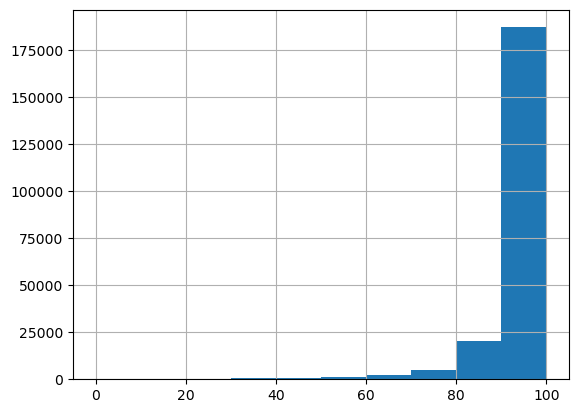

In [44]:
atl_urb_mfr['Occupancy_x'].hist()

In [46]:
# '1BR', '2BR/1Bath', '2BR/2Bath', '3BR+', 'Studio'
atl_urb_mfr['UnitType'].value_counts()

1BR          68917
2BR/2Bath    65598
3BR+         41640
2BR/1Bath    28089
Studio       13001
Name: UnitType, dtype: int64

In [47]:
atl_unit_mean = atl_urb_mfr.groupby(['UnitType', 'Period'])['Rent'].agg(['mean']).reset_index()
atl_unit_mean.pivot(index = 'Period', columns = 'UnitType', values = 'mean')

UnitType,1BR,2BR/1Bath,2BR/2Bath,3BR+,Studio
Period,,,,,
2015-01-01,901.611655,922.826727,1161.674958,1351.173390,919.034275
2015-02-01,908.602998,926.713252,1167.040531,1355.201852,926.319846
2015-03-01,912.756379,932.214398,1177.392197,1362.410260,937.758273
2015-04-01,919.323964,943.168740,1187.696930,1370.949565,944.405547
2015-05-01,920.758643,945.068570,1199.470710,1379.892787,949.296845
2015-06-01,931.104918,961.802086,1213.723425,1396.248230,963.170153
2015-07-01,936.781424,969.205030,1221.229649,1403.658490,959.950686
2015-08-01,944.215690,972.686614,1229.913092,1406.195293,974.073895
2015-09-01,946.717915,975.419749,1229.516633,1398.225053,970.957008


<Axes: xlabel='Period'>

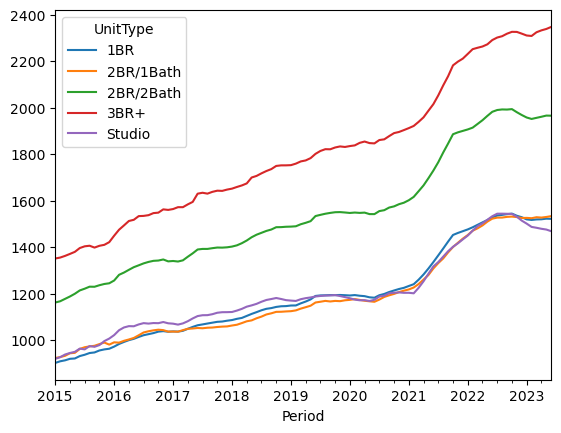

In [48]:
atl_unit_mean.pivot(index = 'Period', columns = 'UnitType', values = 'mean').plot()

In [50]:
atl_zip_mean = atl_urb_mfr.groupby(['zipcode', 'Period'])['Rent'].agg(['mean']).reset_index()
atl_zip_mean = atl_zip_mean.rename({'mean': 'mean_rent_mf', 'Period':'period_start'}, axis = 1)
atl_zip_mean

,zipcode,period_start,mean_rent_mf
0,30002,2015-01-01,630.703297
1,30002,2015-02-01,651.760989
2,30002,2015-03-01,632.815934
3,30002,2015-04-01,640.076923
4,30002,2015-05-01,629.846154
...,...,...,...
5541,30363,2023-02-01,2625.106881
5542,30363,2023-03-01,2622.521827
5543,30363,2023-04-01,2619.936774
5544,30363,2023-05-01,2617.351720


In [51]:
atl_zip_mean['zipcode'] = atl_zip_mean['zipcode'].astype('string')
atl_zip_mean.dtypes

zipcode                 string
period_start    datetime64[ns]
mean_rent_mf           float64
dtype: object

<Axes: xlabel='period_start'>

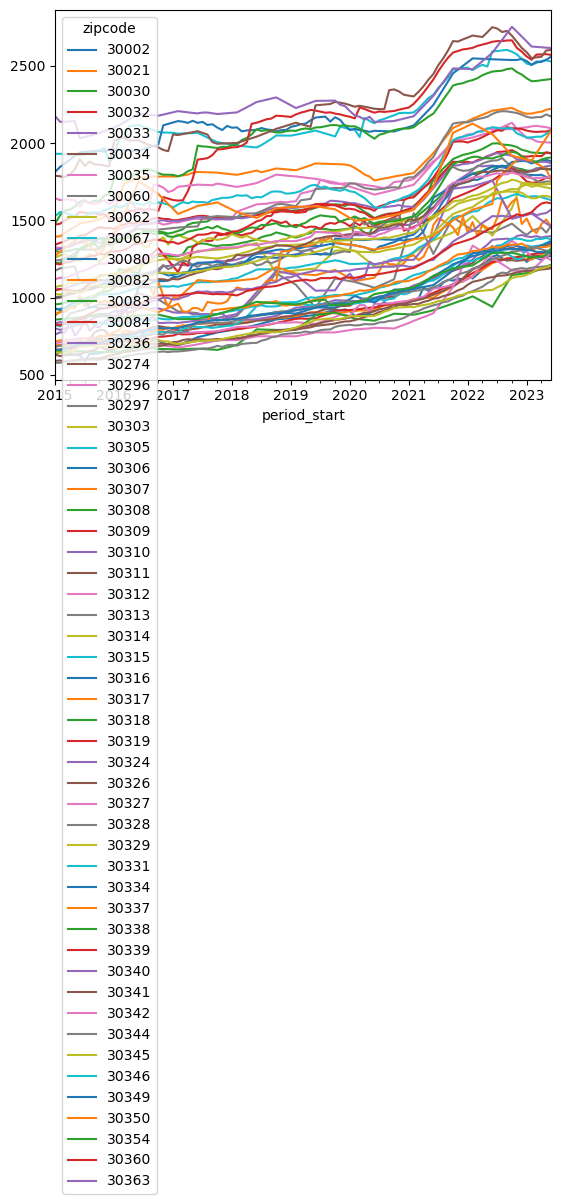

In [52]:
atl_zip_mean.pivot(index = 'period_start', columns = 'zipcode', values = 'mean_rent_mf').plot()

In [54]:
sfr.head()

,period_start,sf_rental_index,zipcode,trans_period,coef,sf_price_index
0,2010-02-01,100.000000,47038,38.0,-0.228594,82.953446
1,2010-03-01,67.975154,47038,39.0,-0.195522,82.872184
2,2010-04-01,78.247524,47038,40.0,-0.185380,82.536945
3,2010-05-01,62.539852,47038,41.0,-0.177184,82.263764
4,2010-06-01,50.101684,47038,42.0,-0.182479,81.827389


In [191]:
sfr[sfr['zipcode'] == '30363']

,period_start,sf_rental_index,zipcode,trans_period,coef,sf_price_index
1157141,2010-01-01,100.000000,30363,37.0,-0.262916,77.776278
1157142,2010-02-01,101.574527,30363,38.0,-0.261970,77.350413
1157143,2010-03-01,99.235421,30363,39.0,-0.279474,77.130027
1157144,2010-04-01,100.440160,30363,40.0,-0.287841,76.434724
1157145,2010-05-01,102.828178,30363,41.0,-0.259250,76.385453
1157146,2010-06-01,100.941860,30363,42.0,-0.280301,76.193156
1157147,2010-07-01,101.061045,30363,43.0,-0.299942,75.727397
1157148,2010-08-01,100.999736,30363,44.0,-0.296876,75.287439
1157149,2010-09-01,101.514585,30363,45.0,-0.319875,74.788401
1157150,2010-10-01,101.667335,30363,46.0,-0.325573,74.325609


In [205]:
sfr['zipcode'].unique()

array(['47038', '47374', '41005', ..., '27107', '27127', '27105'],
      dtype=object)

In [70]:
atl_urb_zip = list(atl_zip_mean['zipcode'].unique())
atl_urb_zip

['30002',
 '30021',
 '30030',
 '30032',
 '30033',
 '30034',
 '30035',
 '30060',
 '30062',
 '30067',
 '30080',
 '30082',
 '30083',
 '30084',
 '30236',
 '30274',
 '30296',
 '30297',
 '30303',
 '30305',
 '30306',
 '30307',
 '30308',
 '30309',
 '30310',
 '30311',
 '30312',
 '30313',
 '30314',
 '30315',
 '30316',
 '30317',
 '30318',
 '30319',
 '30324',
 '30326',
 '30327',
 '30328',
 '30329',
 '30331',
 '30334',
 '30337',
 '30338',
 '30339',
 '30340',
 '30341',
 '30342',
 '30344',
 '30345',
 '30346',
 '30349',
 '30350',
 '30354',
 '30360',
 '30363']

In [56]:
atl_urb_df = pd.merge(atl_zip_mean, sfr, 
                  how = 'left',
                  on = ['zipcode', 'period_start'])
atl_urb_df

,zipcode,period_start,mean_rent_mf,sf_rental_index,trans_period,coef,sf_price_index
0,30002,2015-01-01,630.703297,114.715608,97.0,-0.224999,82.331231
1,30002,2015-02-01,651.760989,115.155485,98.0,-0.207499,82.202391
2,30002,2015-03-01,632.815934,115.694032,99.0,-0.180874,82.423472
3,30002,2015-04-01,640.076923,116.181280,100.0,-0.145673,83.115012
4,30002,2015-05-01,629.846154,117.000157,101.0,-0.126192,84.135504
...,...,...,...,...,...,...,...
5541,30363,2023-02-01,2625.106881,321.929191,194.0,0.471078,159.063094
5542,30363,2023-03-01,2622.521827,323.787196,195.0,0.489442,159.665698
5543,30363,2023-04-01,2619.936774,324.655463,196.0,0.505767,160.315226
5544,30363,2023-05-01,2617.351720,326.057108,197.0,0.509293,162.074694


In [58]:
migration_atl.head()

,area,us_state_id,us_state,us_cbsa_id,us_cbsa,us_county_id,us_county,us_tract_id,us_tract,observation_start_date,observation_end_date,student_population_fraction,population,netflow_estimated,inflow_estimated,outflow_estimated,netflow_estimated_normalized,inflow_estimated_normalized,outflow_estimated_normalized,cumulative_netflow_estimated,median_income_inflow,median_income,median_income_difference,median_age_inflow,median_age,median_age_difference,confidence_score
location_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
13121005501,1192738,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13121,"Fulton County, GA",13121005501,13121005501,2023-06-01,2023-06-30,0.0877,3045,0,13,13,0,12,12,-73,46088.5742,37342,8746.5732,23.3552,30.6,-7.2448,1
13117130413,5159717,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13117,"Forsyth County, GA",13117130413,13117130413,2023-06-01,2023-06-30,0.0217,2725,5,25,20,5,23,19,315,87631.4922,47383,40248.4922,28.1005,44.9,-16.7995,1
13063040523,2666441,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13063,"Clayton County, GA",13063040523,13063040523,2023-06-01,2023-06-30,0.1003,2821,-1,15,16,-1,14,15,-121,31598.7207,43214,-11615.2783,21.2600,33.3,-12.0400,1
13089022900,3903186,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13089,"DeKalb County, GA",13089022900,13089022900,2023-06-01,2023-06-30,0.0225,4044,1,43,42,1,40,39,133,57696.6094,89792,-32095.3887,29.8097,44.4,-14.5903,1
13121007709,3497343,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13121,"Fulton County, GA",13121007709,13121007709,2023-06-01,2023-06-30,0.1179,4921,-2,21,23,-2,20,21,-8,26437.3164,86637,-60199.6836,20.9190,34.6,-13.6810,1


In [85]:
cbsa['census_zcta5_geoid'] = cbsa['census_zcta5_geoid'].astype('string')

In [87]:
cbsa_atl = cbsa[cbsa['census_zcta5_geoid'].isin(atl_urb_zip)]
cbsa_atl

,census_cbsa_geoid,census_cbsa_name,census_cbsa_lsad,census_cbsa_lat,census_cbsa_lon,census_zcta5_geoid,census_zcta5_lat,census_zcta5_lon,census_tract_geoid,census_tract_lat,census_tract_lon
6462,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30309,33.799851,-84.385837,13121001206,33.779546,-84.384954
6463,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30309,33.799851,-84.385837,13121009103,33.803964,-84.397184
6464,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30309,33.799851,-84.385837,13121008908,33.799844,-84.404880
6465,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30309,33.799851,-84.385837,13121000502,33.799892,-84.381035
6466,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30309,33.799851,-84.385837,13121009105,33.806539,-84.388749
6467,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30309,33.799851,-84.385837,13121001101,33.785497,-84.383075
6468,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30309,33.799851,-84.385837,13121001102,33.783020,-84.383146
6469,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30309,33.799851,-84.385837,13121001204,33.778780,-84.380163
6470,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30309,33.799851,-84.385837,13121009104,33.813442,-84.396518
6471,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30309,33.799851,-84.385837,13121000400,33.788324,-84.378511


In [93]:
mig_atl_zip = pd.merge(migration_atl, cbsa_atl, left_on = 'us_tract_id', right_on = 'census_tract_geoid')
mig_atl_zip.head()

,area,us_state_id,us_state,us_cbsa_id,us_cbsa,us_county_id,us_county,us_tract_id,us_tract,observation_start_date,observation_end_date,student_population_fraction,population,netflow_estimated,inflow_estimated,outflow_estimated,netflow_estimated_normalized,inflow_estimated_normalized,outflow_estimated_normalized,cumulative_netflow_estimated,median_income_inflow,median_income,median_income_difference,median_age_inflow,median_age,median_age_difference,confidence_score,census_cbsa_geoid,census_cbsa_name,census_cbsa_lsad,census_cbsa_lat,census_cbsa_lon,census_zcta5_geoid,census_zcta5_lat,census_zcta5_lon,census_tract_geoid,census_tract_lat,census_tract_lon
0,1192738,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13121,"Fulton County, GA",13121005501,13121005501,2023-06-01,2023-06-30,0.0877,3045,0,13,13,0,12,12,-73,46088.5742,37342,8746.5732,23.3552,30.6,-7.2448,1,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30315,33.702741,-84.382853,13121005501,33.729867,-84.383737
1,1192738,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13121,"Fulton County, GA",13121005501,13121005501,2023-05-01,2023-05-31,0.0877,3045,2,19,17,2,17,15,-73,31647.4219,37342,-5694.5781,25.4266,30.6,-5.1734,1,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30315,33.702741,-84.382853,13121005501,33.729867,-84.383737
2,1192738,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13121,"Fulton County, GA",13121005501,13121005501,2023-04-01,2023-04-30,0.0877,3045,2,21,19,2,20,18,-75,44839.8750,37342,7497.8750,25.9229,30.6,-4.6771,1,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30315,33.702741,-84.382853,13121005501,33.729867,-84.383737
3,1192738,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13121,"Fulton County, GA",13121005501,13121005501,2023-03-01,2023-03-31,0.0877,3045,0,23,23,0,21,21,-77,51881.0820,37342,14539.0830,24.3990,30.6,-6.2010,1,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30315,33.702741,-84.382853,13121005501,33.729867,-84.383737
4,1192738,13,Georgia,12060,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",13121,"Fulton County, GA",13121005501,13121005501,2023-02-01,2023-02-28,0.0877,3045,1,21,20,1,21,20,-77,71491.5703,37342,34149.5742,28.4193,30.6,-2.1807,1,12060.0,"Atlanta-Sandy Springs-Alpharetta, GA",M1,33.693728,-84.399911,30315,33.702741,-84.382853,13121005501,33.729867,-84.383737


In [117]:
mig_atl_zip_group = mig_atl_zip.groupby(['census_zcta5_geoid', 'observation_start_date']).agg({
    'student_population_fraction': 'mean', 
    'population': 'sum', 
    'netflow_estimated': 'sum',
    'inflow_estimated': 'sum',
    'outflow_estimated': 'sum',
    'netflow_estimated_normalized': 'sum',
    'inflow_estimated_normalized': 'sum',
    'outflow_estimated_normalized': 'sum',
    'cumulative_netflow_estimated': 'sum',
    'median_income_inflow': 'mean',
    'median_income': 'mean',
    'median_age_inflow': 'mean',
    'median_age': 'mean'
}).reset_index()
mig_atl_zip_group
# median income and median age stay constant - are these based on the start date?

# does this map from cencus tract to zipcode make sense?

,census_zcta5_geoid,observation_start_date,student_population_fraction,population,netflow_estimated,inflow_estimated,outflow_estimated,netflow_estimated_normalized,inflow_estimated_normalized,outflow_estimated_normalized,cumulative_netflow_estimated,median_income_inflow,median_income,median_age_inflow,median_age
0,30002,2018-12-01,0.0371,2371,-7,17,24,-6,15,22,0,57063.0000,96859.0,18.9250,46.0
1,30002,2019-01-01,0.0371,2371,-6,22,28,-5,20,25,-6,60950.8125,96859.0,24.2750,46.0
2,30002,2019-02-01,0.0371,2371,-6,22,28,-6,22,28,-12,77031.0000,96859.0,29.9750,46.0
3,30002,2019-03-01,0.0371,2371,-5,23,28,-5,21,25,-17,103704.9375,96859.0,30.7719,46.0
4,30002,2019-04-01,0.0371,2371,-8,25,33,-7,23,31,-25,47652.5938,96859.0,22.0531,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,30363,2023-02-01,0.2238,3842,-3,44,47,-3,44,47,-502,45261.9063,82917.0,22.6056,30.5
2966,30363,2023-03-01,0.2238,3842,-8,42,50,-7,38,45,-510,50429.4102,82917.0,23.9363,30.5
2967,30363,2023-04-01,0.2238,3842,-11,40,51,-10,37,48,-521,36777.9805,82917.0,24.2210,30.5
2968,30363,2023-05-01,0.2238,3842,-12,44,56,-11,40,51,-533,52505.3867,82917.0,22.4216,30.5


In [119]:
atl_df_final = pd.merge(atl_urb_df, mig_atl_zip_group, 
                        left_on = ['zipcode', 'period_start'],
                        right_on = ['census_zcta5_geoid', 'observation_start_date'])
#atl_df_final.drop(['area', 'us_state_id', 'us_state', 'us_cbsa_id', 'us_cbsa', 'us_county_id',
 #                 'us_county', 'us_tract', 'observation_end_date'], axis=1, inplace = True)
atl_df_final.head()

,zipcode,period_start,mean_rent_mf,sf_rental_index,trans_period,coef,sf_price_index,census_zcta5_geoid,observation_start_date,student_population_fraction,population,netflow_estimated,inflow_estimated,outflow_estimated,netflow_estimated_normalized,inflow_estimated_normalized,outflow_estimated_normalized,cumulative_netflow_estimated,median_income_inflow,median_income,median_age_inflow,median_age
0,30002,2018-12-01,864.321429,139.455839,144.0,0.112014,112.494762,30002,2018-12-01,0.0371,2371,-7,17,24,-6,15,22,0,57063.0000,96859.0,18.9250,46.0
1,30002,2019-01-01,866.969780,140.034157,145.0,0.108432,112.353442,30002,2019-01-01,0.0371,2371,-6,22,28,-5,20,25,-6,60950.8125,96859.0,24.2750,46.0
2,30002,2019-02-01,870.157967,140.591074,146.0,0.136117,112.587389,30002,2019-02-01,0.0371,2371,-6,22,28,-6,22,28,-12,77031.0000,96859.0,29.9750,46.0
3,30002,2019-03-01,878.043956,141.285830,147.0,0.154795,113.908682,30002,2019-03-01,0.0371,2371,-5,23,28,-5,21,25,-17,103704.9375,96859.0,30.7719,46.0
4,30002,2019-04-01,881.304945,142.134718,148.0,0.146306,114.133338,30002,2019-04-01,0.0371,2371,-8,25,33,-7,23,31,-25,47652.5938,96859.0,22.0531,46.0


In [120]:
atl_df_final.groupby(['zipcode']).corr()

/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_79177/4114326768.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.corr is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  atl_df_final.groupby(['zipcode']).corr()


mean_rent_mf  sf_rental_index  \
zipcode                                                               
30002   mean_rent_mf                      1.000000         0.989116   
        sf_rental_index                   0.989116         1.000000   
        trans_period                      0.965102         0.976417   
        coef                              0.979597         0.987330   
        sf_price_index                    0.990952         0.995830   
...                                            ...              ...   
30363   cumulative_netflow_estimated     -0.838979        -0.976326   
        median_income_inflow             -0.100372        -0.111625   
        median_income                          NaN              NaN   
        median_age_inflow                -0.390340        -0.360310   
        median_age                             NaN              NaN   

                                      trans_period      coef  sf_price_index  \
zipcode                                                                        
30002   mean_rent_mf                      0.965102  0.979597        0.990952   
        sf_rental_index                   0.976417  0.987330        0.995830   
        trans_period                      1.000000  0.981463        0.979747   
        coef                              0.981463  1.000000        0.988720   
        sf_price_index                    0.979747  0.988720        1.000000   
...                                            ...       ...             ...   
30363   cumulative_netflow_estimated     -0.998435 -0.981427       -0.981399   
        median_income_inflow             -0.102611 -0.121153       -0.093509   
        median_income                          NaN       NaN             NaN   
        median_age_inflow                -0.334644 -0.342188       -0.357134   
        median_age                             NaN       NaN             NaN   

                                      student_population_fraction  population  \
zipcode                                                                         
30002   mean_rent_mf                                          NaN         NaN   
        sf_rental_index                                       NaN         NaN   
        trans_period                                          NaN         NaN   
        coef                                                  NaN         NaN   
        sf_price_index                                        NaN         NaN   
...                                                           ...         ...   
30363   cumulative_netflow_estimated                          NaN         NaN   
        median_income_inflow                                  NaN         NaN   
        median_income                                         NaN         NaN   
        median_age_inflow                                     NaN         NaN   
        median_age                                            NaN         NaN   

                                      netflow_estimated  inflow_estimated  \
zipcode                                                                     
30002   mean_rent_mf                           0.240887         -0.423730   
        sf_rental_index                        0.260678         -0.442982   
        trans_period                           0.329240         -0.386135   
        coef                                   0.285793         -0.381729   
        sf_price_index                         0.254826         -0.432450   
...                                                 ...               ...   
30363   cumulative_netflow_estimated           0.195854          0.427137   
        median_income_inflow                  -0.008786          0.318479   
        median_income                               NaN               NaN   
        median_age_inflow                     -0.136558          0.412151   
        median_age                                  NaN               NaN   

                 

/Users/emmydanforth/anaconda3/lib/python3.10/site-packages/typeguard/__init__.py:1033: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  retval = func(*args, **kwargs)


<Axes: xlabel='Time'>

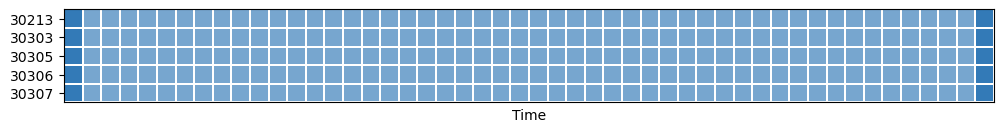

In [208]:
from pandas_profiling.visualisation.plot import timeseries_heatmap

timeseries_heatmap(dataframe=atl_df, entity_column='zipcode', sortby='period_start')

In [209]:
from pandas_profiling import ProfileReport

profile = ProfileReport(atl_df, tsmode=True, sortby='period_start')
profile.to_file('profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/emmydanforth/anaconda3/lib/python3.10/site-packages/multimethod/__init__.py:315: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  return func(*args, **kwargs)
/Users/emmydanforth/anaconda3/lib/python3.10/site-packages/multimethod/__init__.py:315: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='period_start'>

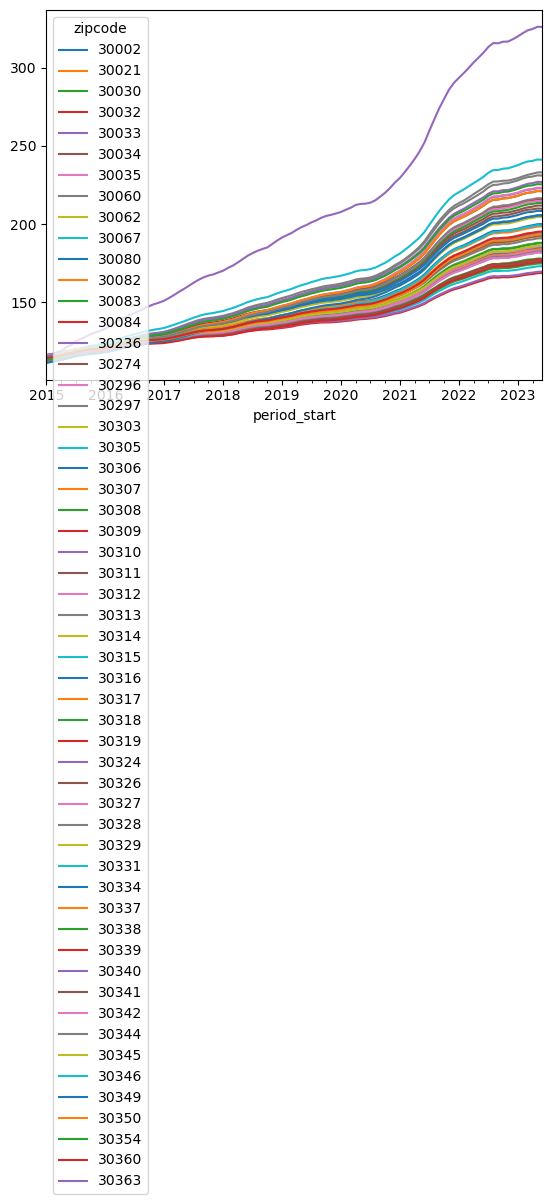

In [128]:
sfr_zip = atl_df.pivot(index = 'period_start', columns = 'zipcode', values = 'sf_rental_index')
sfr_zip.plot()

In [100]:
sfr_zip_samp = sfr_zip[['30363']]

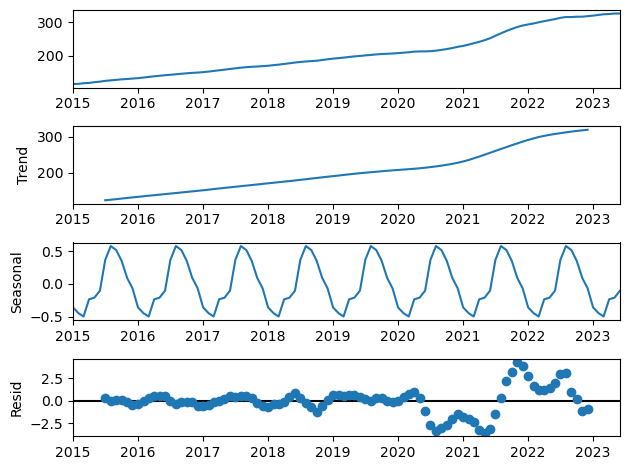

In [101]:
result = seasonal_decompose(sfr_zip_samp)
result.plot()
plt.show()

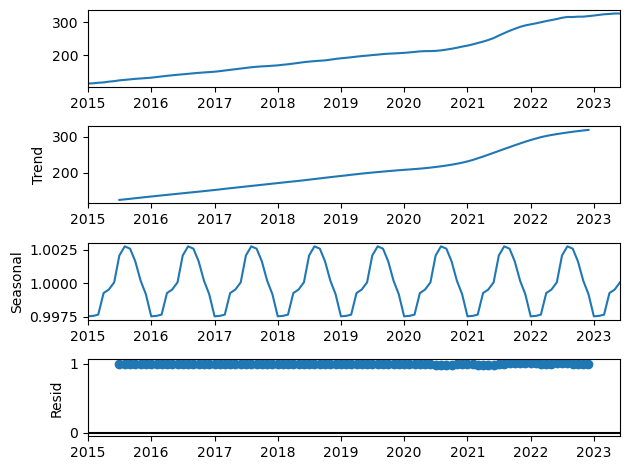

In [102]:
result = seasonal_decompose(sfr_zip_samp, model = 'multiplicative')
result.plot()
plt.show()

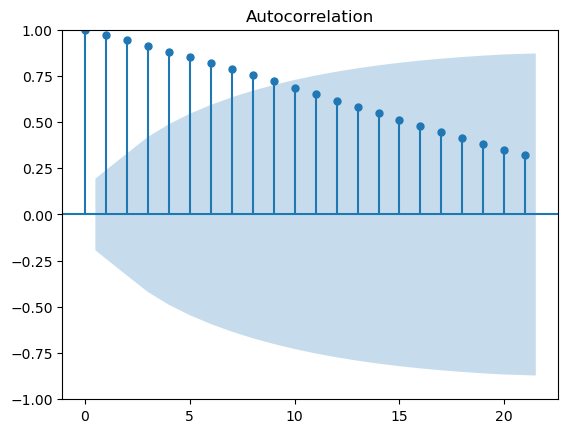

In [225]:
plot_acf(sfr_zip_samp)
plt.show()
# high autocorrelation for distance observations
# suggesting smooth time series and high linear dependence between observations

/Users/emmydanforth/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


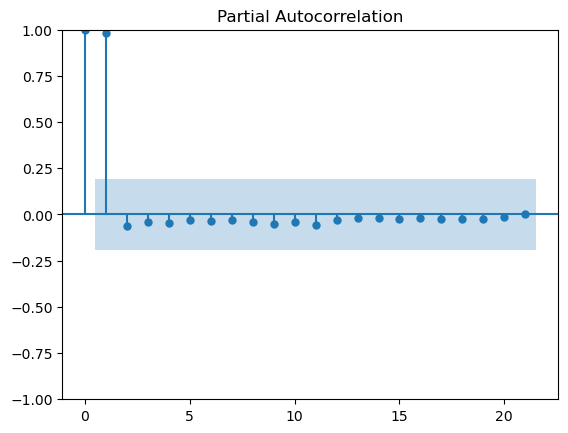

In [226]:
plot_pacf(sfr_zip_samp)
plt.show()
# significant information added in lags 1-2

In [104]:
atl_urb_df.head()

,zipcode,period_start,mean_rent_mf,sf_rental_index,trans_period,coef,sf_price_index
0,30002,2015-01-01,630.703297,114.715608,97.0,-0.224999,82.331231
1,30002,2015-02-01,651.760989,115.155485,98.0,-0.207499,82.202391
2,30002,2015-03-01,632.815934,115.694032,99.0,-0.180874,82.423472
3,30002,2015-04-01,640.076923,116.181280,100.0,-0.145673,83.115012
4,30002,2015-05-01,629.846154,117.000157,101.0,-0.126192,84.135504


In [123]:
atl_urb_df.corr()
# low correlation between mfr and sfr when looking at aggregate - why?

/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_79177/613357534.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  atl_urb_df.corr()


,mean_rent_mf,sf_rental_index,trans_period,coef,sf_price_index
mean_rent_mf,1.000000,0.321990,0.428309,0.534657,0.533641
sf_rental_index,0.321990,1.000000,0.868847,0.855357,0.865065
trans_period,0.428309,0.868847,1.000000,0.972799,0.964042
coef,0.534657,0.855357,0.972799,1.000000,0.991007
sf_price_index,0.533641,0.865065,0.964042,0.991007,1.000000


In [126]:
corr = atl_urb_df.groupby(['zipcode']).corr()
corr
# broken down by zipode, correlation tends to be high

/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_79177/592507242.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.corr is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  corr = atl_urb_df.groupby(['zipcode']).corr()


mean_rent_mf  sf_rental_index  trans_period  \
zipcode                                                                
30002   mean_rent_mf         1.000000         0.991919      0.975126   
        sf_rental_index      0.991919         1.000000      0.968187   
        trans_period         0.975126         0.968187      1.000000   
        coef                 0.984345         0.981711      0.991276   
        sf_price_index       0.994504         0.995864      0.982549   
30021   mean_rent_mf         1.000000         0.993233      0.946339   
        sf_rental_index      0.993233         1.000000      0.966927   
        trans_period         0.946339         0.966927      1.000000   
        coef                 0.968376         0.984685      0.989725   
        sf_price_index       0.989759         0.996922      0.978458   
30030   mean_rent_mf         1.000000         0.970036      0.969369   
        sf_rental_index      0.970036         1.000000      0.969524   
        trans_period         0.969369         0.969524      1.000000   
        coef                 0.981335         0.981361      0.991923   
        sf_price_index       0.977449         0.995421      0.984582   
30032   mean_rent_mf         1.000000         0.997217      0.965217   
        sf_rental_index      0.997217         1.000000      0.969274   
        trans_period         0.965217         0.969274      1.000000   
        coef                 0.975792         0.982590      0.991318   
        sf_price_index       0.993951         0.996514      0.981889   
30033   mean_rent_mf         1.000000         0.994337      0.958234   
        sf_rental_index      0.994337         1.000000      0.967439   
        trans_period         0.958234         0.967439      1.000000   
        coef                 0.977205         0.982354      0.991136   
        sf_price_index       0.987506         0.995479      0.982547   
30034   mean_rent_mf         1.000000         0.994877      0.961701   
        sf_rental_index      0.994877         1.000000      0.968652   
        trans_period         0.961701         0.968652      1.000000   
        coef                 0.979585         0.984597      0.989419   
        sf_price_index       0.994290         0.997724      0.977085   
30035   mean_rent_mf         1.000000         0.980315      0.924595   
        sf_rental_index      0.980315         1.000000      0.968087   
        trans_period         0.924595         0.968087      1.000000   
        coef                 0.954287         0.986635      0.988290   
        sf_price_index       0.981116         0.998110      0.974202   
30060   mean_rent_mf         1.000000         0.916562      0.887568   
        sf_rental_index      0.916562         1.000000      0.968005   
        trans_period         0.887568         0.968005      1.000000   
        coef                 0.914027         0.992535      0.984330   
        sf_price_index       0.911995         0.998721      0.967112   
30062   mean_rent_mf         1.000000         0.864228      0.823761   
        sf_rental_index      0.864228         1.000000      0.964440   
        trans_period         0.823761         0.964440      1.000000   
        coef                 0.852342         0.992917      0.981500   
        sf_price_index       0.864356         0.998613      0.963314   
30067   mean_rent_mf         1.000000         0.995462      0.950615   
        sf_rental_index      0.995462         1.000000      0.965378   
        trans_period         0.950615         0.965378      1.000000   
        coef                 0.983672         0.991057      0.985138   
        sf_price_index       0.994130         0.998407      0.969408   
30080   mean_rent_mf         1.000000         0.991083      0.943197   
        sf_rental_index      0.991083         1.000000      0.966632   
        trans_period         0.943197         0.966632      1.000000   
        coef                 0.978114         0.990138      0.987

In [ ]:
# Creating MFR Occupancy Rate and Rental Index by Zipcode

In [154]:
atl_occ = pd.merge(mf_occ, atl_urb_prop, on = 'PID')
atl_occ = atl_occ[['PID', 'Period', 'Occupancy_x', 'nounits', 'zipcode']]
atl_occ

,PID,Period,Occupancy_x,nounits,zipcode
0,22_53,2015-01-01,95.3,148,30274
1,22_53,2015-02-01,95.3,148,30274
2,22_53,2015-03-01,95.3,148,30274
3,22_53,2015-04-01,94.6,148,30274
4,22_53,2015-05-01,95.3,148,30274
...,...,...,...,...,...
79634,22_1414869,2023-02-01,86.6,238,30311
79635,22_1414869,2023-03-01,84.5,238,30311
79636,22_1414869,2023-04-01,81.9,238,30311
79637,22_1414869,2023-05-01,79.8,238,30311


In [158]:
atl_occ['Occupancy_x'] = atl_occ['Occupancy_x']/100
atl_occ['occupied_units'] = atl_occ['Occupancy_x'] * atl_occ['nounits']
atl_occ = atl_occ.groupby(['zipcode', 'Period'], as_index=False)[['nounits','occupied_units']].sum()
atl_occ['occupancy_by_zip'] = atl_occ['occupied_units'] / atl_occ['nounits']
atl_occ

,zipcode,Period,nounits,occupied_units,occupancy_by_zip
0,30002,2015-01-01,592,538.940,0.910372
1,30002,2015-02-01,592,538.940,0.910372
2,30002,2015-03-01,592,540.248,0.912581
3,30002,2015-04-01,592,537.196,0.907426
4,30002,2015-05-01,592,537.196,0.907426
...,...,...,...,...,...
5541,30363,2023-02-01,1541,1333.632,0.865433
5542,30363,2023-03-01,1541,1327.538,0.861478
5543,30363,2023-04-01,1541,1322.808,0.858409
5544,30363,2023-05-01,1541,1318.465,0.855591


In [180]:
atl_rent = pd.merge(mf_rent, atl_urb_prop, on = 'PID')
atl_rent = atl_rent[['PID', 'Period', 'UnitType', 'Rent', 'nounits', 'zipcode']]
atl_rent

,PID,Period,UnitType,Rent,nounits,zipcode
0,22_1004844,2015-01-01,1BR,1080.774194,366,30338
1,22_1004844,2015-02-01,1BR,1138.064516,366,30338
2,22_1004844,2015-03-01,1BR,1127.903226,366,30338
3,22_1004844,2015-04-01,1BR,1117.741935,366,30338
4,22_1004844,2015-05-01,1BR,1107.580645,366,30338
...,...,...,...,...,...,...
246272,22_9894,2023-02-01,Studio,1319.000000,339,30339
246273,22_9894,2023-03-01,Studio,1324.000000,339,30339
246274,22_9894,2023-04-01,Studio,1324.000000,339,30339
246275,22_9894,2023-05-01,Studio,1324.000000,339,30339


In [162]:
atl_rent['UnitType'].unique()

array(['1BR', '2BR/1Bath', '2BR/2Bath', '3BR+', 'Studio'], dtype=object)

In [181]:
tenant_dict = {'Studio': 1, '1BR': 1, '2BR/1Bath': 2, '2BR/2Bath':2, '3BR+': 3}
atl_rent['tenants'] = atl_rent['UnitType'].map(tenant_dict)
atl_rent

,PID,Period,UnitType,Rent,nounits,zipcode,tenants
0,22_1004844,2015-01-01,1BR,1080.774194,366,30338,1
1,22_1004844,2015-02-01,1BR,1138.064516,366,30338,1
2,22_1004844,2015-03-01,1BR,1127.903226,366,30338,1
3,22_1004844,2015-04-01,1BR,1117.741935,366,30338,1
4,22_1004844,2015-05-01,1BR,1107.580645,366,30338,1
...,...,...,...,...,...,...,...
246272,22_9894,2023-02-01,Studio,1319.000000,339,30339,1
246273,22_9894,2023-03-01,Studio,1324.000000,339,30339,1
246274,22_9894,2023-04-01,Studio,1324.000000,339,30339,1
246275,22_9894,2023-05-01,Studio,1324.000000,339,30339,1


In [182]:
atl_rent = atl_rent.groupby(['zipcode', 'Period'], as_index=False)[['tenants', 'Rent']].sum()
atl_rent

,zipcode,Period,tenants,Rent
0,30002,2015-01-01,14,5207.813187
1,30002,2015-02-01,14,5331.043956
2,30002,2015-03-01,14,5229.263736
3,30002,2015-04-01,14,5232.307692
4,30002,2015-05-01,14,5165.384615
...,...,...,...,...
5694,30363,2023-02-01,28,39376.603213
5695,30363,2023-03-01,28,39337.827409
5696,30363,2023-04-01,28,39299.051604
5697,30363,2023-05-01,28,39260.275800


In [184]:
atl_rent['rent_per_person'] = atl_rent['Rent'] / atl_rent['tenants']
atl_rent

,zipcode,Period,tenants,Rent,rent_per_person
0,30002,2015-01-01,14,5207.813187,371.986656
1,30002,2015-02-01,14,5331.043956,380.788854
2,30002,2015-03-01,14,5229.263736,373.518838
3,30002,2015-04-01,14,5232.307692,373.736264
4,30002,2015-05-01,14,5165.384615,368.956044
...,...,...,...,...,...
5694,30363,2023-02-01,28,39376.603213,1406.307258
5695,30363,2023-03-01,28,39337.827409,1404.922407
5696,30363,2023-04-01,28,39299.051604,1403.537557
5697,30363,2023-05-01,28,39260.275800,1402.152707


In [188]:
atl_rent.describe()

,zipcode,tenants,Rent,rent_per_person
count,5699.000000,5699.000000,5699.000000,5699.000000
mean,30250.694332,78.588173,59737.145964,726.235429
std,122.071742,62.329152,56163.238002,270.172246
min,30002.000000,2.000000,625.000000,286.351375
25%,30084.000000,27.000000,16035.772910,507.253879
50%,30313.000000,66.000000,45080.907493,679.965177
75%,30337.000000,123.000000,86365.004681,911.434931
max,30363.000000,287.000000,313340.944231,1521.079284


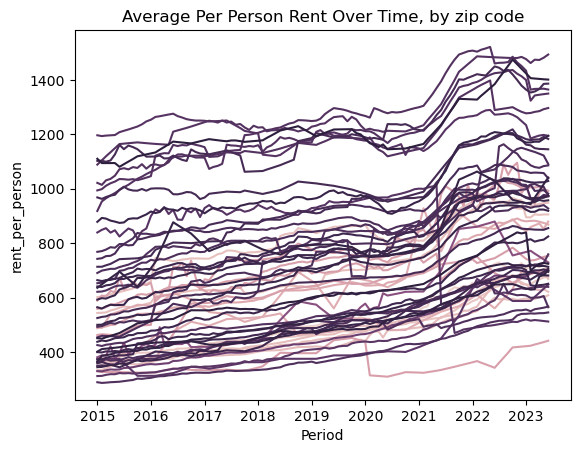

In [187]:
sns.lineplot(data=atl_rent, x='Period', y='rent_per_person', hue='zipcode', legend=False)
plt.title('Average Per Person Rent Over Time, by zip code')
plt.show()